# Module 9: Repetition

In an effort to modernize our sales process, management wants to target the advertisment for customers better. Market research has concluded that this kind of advertisment is best used when the customer is in the process of ordering new products.

Our task is to build system that predicts the time when a customer orders the next batch.

For this we need to:
- Analyze the historic data to identify features that can be used for prediction
- Preprocess the data for the following steps
- Build our system or model for prediction
- Evaluate the feasability of the idea 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from pandas.core.algorithms import value_counts

try:
    # Try to use the BI style sheet for plots
    plt.style.use('matplotlibrc')
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[(136/256, 76/256, 255/256), (60/256, 170/256, 207/256), (12/256, 229/256, 177/256)]) 
    
    colors = [(0.53125, 0.296875, 0.99609375), (0.453125, 0.3984375, 0.9453125), (0.375, 0.4921875, 0.89453125), (0.3046875, 0.578125, 0.8515625), (0.234375, 0.6640625, 0.80859375), (0.16015625, 0.75390625, 0.76171875), (0.09375, 0.8359375, 0.72265625), (0.046875, 0.89453125, 0.69140625), (0.0, 0.875, 0.6640625)]
    bicmap = LinearSegmentedColormap.from_list(name='BIcmp', 
                                                colors=colors,
                                                N=len(colors))
    cm_bright = ListedColormap([(0.53125, 0.296875, 0.99609375), (12/256, 229/256, 177/256)])
except:
    bicmap = plt.cm.BuGn 
    colors = ['r', 'g', 'b']

## **Exercise 9.1: Exploratory Data Analysis**

We have the following two datasets available:
- `Customers`: Contains the data about the contact person that makes the orders.
- `Order History`: Contains the orders placed by each person for the past 1000 days.

**Make yourself familiar with the data**

In [2]:
# Load the dataset
customers = pd.read_csv(
    'customers.csv',
    index_col='customer_id',
    parse_dates=['birth_date', 'customer_since'])
customers.head()

,first_name,last_name,birth_date,client_group,country,user_agent,phone_number,email_provider,postal_code,street_address,credit_card_number,credit_card_provider,iban,customer_since
customer_id,,,,,,,,,,,,,,
151,Zoey,Jansse,1954-07-14,Physician,Netherlands,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,057 3268174,gmail.com,3453 CD,Jessesingel 092,4234913545964337852,VISA 19 digit,NL07QTND3757675521,2014-04-02
92,Kristen,Hoffman,1973-01-23,Pharmacist,United States,Mozilla/5.0 (Windows NT 5.2; as-IN; rv:1.9.2.2...,001-163-449-9128x15545,hotmail.com,08714,5402 Rogers Ford Apt. 658,4229381486053797,JCB 16 digit,GB32GOQD73595599061566,2010-09-02
23,Janet,Hodgson,1988-08-05,Physician,Great Britain,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,(0191) 496 0144,gmail.com,IM5R 9LW,78 Jeremy spur,4369738718908744,JCB 16 digit,GB83EOKU09925356128355,2011-12-01
446,Susana,Vélez,1959-03-22,Pharmacist,Spain,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.5.20) G...,+34968 52 50 24,hotmail.com,09788,Via Cándido Mate 894 Apt. 92,3517328815692467,VISA 16 digit,ES2870145896488648151053,2018-09-06
375,Caitlin,Parrish,1970-09-17,Specialist,Australia,Mozilla/5.0 (iPad; CPU iPad OS 6_1_6 like Mac ...,0382094833,yahoo.com,0980,Suite 825\n 40 Jeffrey Beach,180056187837749,American Express,GB91UMST97437818012230,2011-05-30


In [3]:
order_history = pd.read_csv(
    'order_history.csv',
    index_col=[0, 1],
    parse_dates=True)
order_history.index.names = ['target', 'customer_id']
order_history

volume
target     customer_id            
2019-09-01 375          110.454220
           417          109.951653
           30            61.963142
           390          104.211573
           66           123.841333
...                            ...
2021-09-19 387          344.881164
           6            208.246431
           154          244.012238
           136           44.809004
           287           61.638719

[7548 rows x 1 columns]

In [4]:
# Define which variables you want to use as features
features = ['country', 'customer_since', 'client_group']

In [5]:
# The target variable will be the number of days between each order from each customer
target = order_history.reset_index(level=0).groupby(level=0).diff().dropna()['target'].dt.days
target

customer_id
375     16
375     37
375      7
375     10
375     25
      ... 
449    103
399     22
399     81
331      2
298     10
Name: target, Length: 7099, dtype: int64

In [6]:
# Our features will be
x = customers.loc[target.index, features]
x

,country,customer_since,client_group
customer_id,,,
375,Australia,2011-05-30,Specialist
375,Australia,2011-05-30,Specialist
375,Australia,2011-05-30,Specialist
375,Australia,2011-05-30,Specialist
375,Australia,2011-05-30,Specialist
...,...,...,...
449,Netherlands,2014-12-31,Specialist
399,Netherlands,2012-12-11,Physician
399,Netherlands,2012-12-11,Physician


## **Exercise 9.2: Preprocessing**

In [7]:
# Preprocess the data
# Tip: Use sklearn's pipeline to working with train/test splits easier
# Tip: You can use make_column_transformer and make_column_selector for this
from sklearn.compose import make_column_selector, make_column_transformer
# Tip: You can use the Standard scaler for numeric data (dtype_include=np.number)
# Tip: You can use the OneHotEncoder for categorical data (dtype_include=object)
from sklearn.preprocessing import StandardScaler, OneHotEncoder

ct = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(categories=[customers[s].unique() for s in ['country', 'client_group']]), make_column_selector(dtype_include=object))
)

In [8]:
# Test the pipeline
ct.fit_transform(x).toarray()

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.]])

## **Exercise 9.3: Modeling**

**First Benchmark**

In [9]:
# We want to measure our performance against a really simple benchmark
# Always predict the average time between orders
from sklearn.dummy import DummyRegressor

bench1 = DummyRegressor(strategy='constant', constant=target.mean())
bench1.fit(x, target)

DummyRegressor(constant=array(37.0373292), strategy='constant')

**Second Benchmark**

In [10]:
# This more advanced benchmark takes the average time between orders of each customer
bench2 = target.groupby(level=0).mean().loc[customers.loc[target.index].index]

### **Exercise 9.3.1: Simple solution**

In [11]:
# We can start with a simple model first
from sklearn.linear_model import LinearRegression

In [12]:
# Create a pipeline with your preprocessing pipeline and the LinearRegression() model
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(ct, LinearRegression())

In [13]:
# Evalaute the pipeline against the benchmarks
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score

print(f'[ML model]: {np.mean(cross_val_score(pipe, x, target, scoring=make_scorer(mean_squared_error)))}')

print(f'[Bench 1]: {mean_squared_error(target, bench1.predict(x))}')

print(f'[Bench 2]: {mean_squared_error(target, bench2)}')

[ML model]: 3412.9832597961476
[Bench 1]: 3215.4406406200387
[Bench 2]: 1816.2965925717563


### **9.3.2: Optimization**

**Use some form of optimization to find a model that performs better than benchmark 1**  
Options:
- Manual search
- Grid search
- Random search
- Bayesian optimization

Tip: You can treat the model as a hyperparameter and search for the best model and the best hyperparameter combination at the same time.

Tip: It might suffice to just use a complex instead of a linear model


In [14]:
from sklearn.svm import SVR

pipe = make_pipeline(ct, SVR())
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'svr', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__standardscaler', 'columntransformer__onehotencoder', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'columntransformer__onehotencoder__categories', 'columntransformer__onehotencoder__drop', 'columntransformer__onehotencoder__dtype', 'columntransformer__onehotencoder__handle_unknown', 'columntransformer__onehotencoder__sparse', 'svr__C', 'svr__cache_size', 'svr__coef0', 'svr__degree', 'svr__epsilon', 'svr__gamma', 'svr__kernel', 'svr__max_iter', 'svr__shrinking', 'svr__tol', 'svr__verbose'])

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

params = {'svr__C': loguniform(1e0, 1e3),
 'svr__gamma': loguniform(1e-4, 1e-3),
 'svr__kernel': ['rbf']}

rs = RandomizedSearchCV(pipe, params, n_jobs=-1, n_iter=10, scoring=make_scorer(mean_squared_error)).fit(x, target)

In [16]:
# Evalaute the pipeline against the benchmarks

print(f'[ML model]: {np.mean(cross_val_score(pipe.set_params(**rs.best_params_), x, target, scoring=make_scorer(mean_squared_error)))}')

print(f'[Bench 1]: {mean_squared_error(target, bench1.predict(x))}')

print(f'[Bench 2]: {mean_squared_error(target, bench2)}')

[ML model]: 3675.432072319265
[Bench 1]: 3215.4406406200387
[Bench 2]: 1816.2965925717563


### **Exercise 9.3.3: Outlier detection and Segmentation**

In [17]:
# We can aggregate the order_history data to visualize the behavior of each of our customers
avg_order_freq = target.groupby(level=0).mean()
avg_order_size = order_history.groupby(level=-1).mean()

agg_customers = avg_order_freq.to_frame().join(avg_order_size)
agg_customers

,target,volume
customer_id,,
0,40.222222,224.715800
1,237.500000,46.915333
2,80.666667,320.469163
3,52.357143,222.244127
4,76.111111,308.207783
...,...,...
445,120.500000,58.306268
446,28.291667,79.414502
447,10.955882,105.670007


<AxesSubplot:xlabel='target', ylabel='volume'>

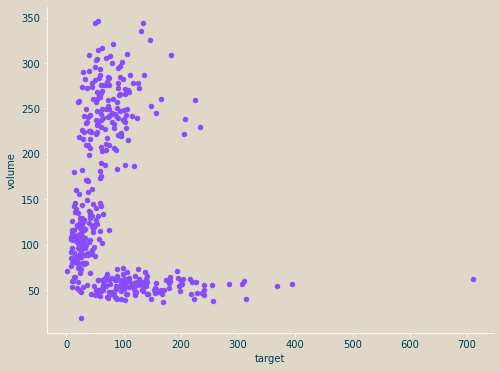

In [18]:
agg_customers.plot.scatter(x='target', y='volume')

In this image we can see two thinks:
- There seem to be clusters of similar behaving customers (segement the data and build one model per segment)
- There are a lot of outliers that can reduce our prediction accuracy (remove outliers to improved the learned function)

Depending on the algorithm you choose you can segment the data and do outlier removal at the same time or do it separately.
It is important, that you measure the impact of your decisions at each step, to validate that they are actually beneficial.

In [19]:
# Let's segment the data with the KMeans algorithm
# We should use the elbow method or the silhouette score to choose the right number of clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

s_score = []
inertia = []
num_k = list(range(2, 10+1))

for k in num_k:
    kmeans = KMeans(n_clusters=k).fit(agg_customers)
    inertia.append(-kmeans.score(agg_customers))
    s_score.append(silhouette_score(agg_customers, kmeans.predict(agg_customers)))

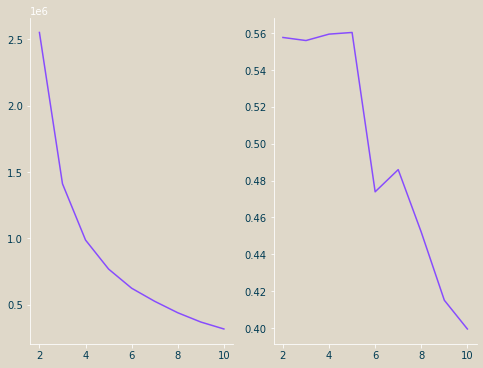

In [20]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(num_k, inertia)
ax[1].plot(num_k, s_score)

<AxesSubplot:xlabel='target', ylabel='volume'>

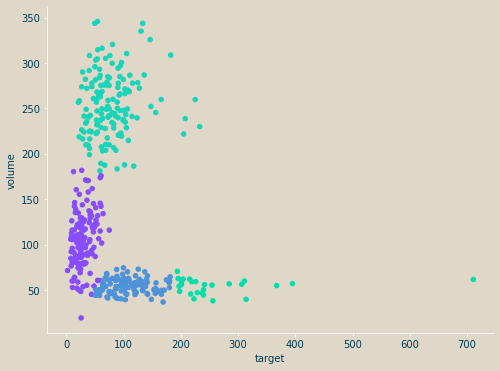

In [21]:
# According to our analysis we should use 4 clusters
cluster_alg = KMeans(n_clusters=4).fit(agg_customers)
# Let's plot the results
agg_customers.plot.scatter(x='target', y='volume', c=cluster_alg.predict(agg_customers), cmap=bicmap, colorbar=False)

In [22]:
results = []
bench1_results = []
bench2_results = []

cluster_size = []

for cluster_id in range(4):
    
    # prediction for one cluster
    ids = agg_customers[(cluster_alg.predict(agg_customers) == cluster_id)].index
    x_segment = x.loc[ids]
    target_segment = target.loc[ids]

    print(ids.size)

    results.append(np.mean(cross_val_score(pipe, x.loc[ids], target.loc[ids], scoring=make_scorer(mean_squared_error))))
    print(f'[ML model]: {results[-1]:0.2f}')

    # Build a new Regressor for each segment
    dr = DummyRegressor(strategy='constant', constant=target.mean())
    dr.fit(x.loc[ids], target.loc[ids])
    bench1_results.append(mean_squared_error(target.loc[ids], dr.predict(x.loc[ids])))
    print(f'[Bench 1]: {bench1_results[-1]:0.2f}')

    bench2_results.append(mean_squared_error(target.loc[ids], target.loc[ids].groupby(level=0).mean().loc[customers.loc[target.loc[ids].index].index]))
    print(f'[Bench 2]: {bench2_results[-1]:0.2f}')

    cluster_size.append(ids.size)
    print('#'*30)

159
[ML model]: 732.33
[Bench 1]: 907.11
[Bench 2]: 508.63
##############################
111
[ML model]: 8778.52
[Bench 1]: 11920.90
[Bench 2]: 6925.07
##############################
146
[ML model]: 4959.76
[Bench 1]: 5068.97
[Bench 2]: 3452.29
##############################
26
[ML model]: 36566.61
[Bench 1]: 78785.96
[Bench 2]: 29202.76
##############################


In [23]:
# Calculate the total gain of the change
weights = np.array(cluster_size)/np.sum(cluster_size)

print(f'[ML model]: {np.average(results, weights=weights)}')

print(f'[Bench 1]: {np.average(bench1_results, weights=weights)}')

print(f'[Bench 2]: {np.average(bench2_results, weights=weights)}')

[ML model]: 6257.268963012758
[Bench 1]: 9628.858630747194
[Bench 2]: 4780.229399840364


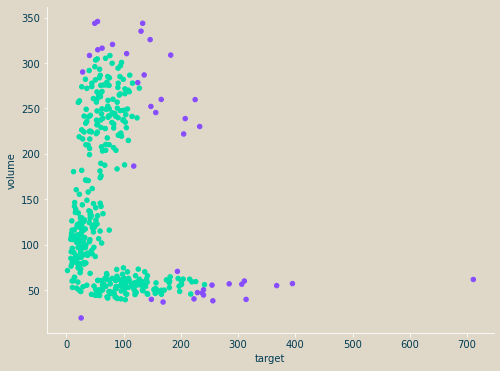

In [24]:
# Remove the outliers with a method of your choice
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(n_jobs=-1, contamination=0.09).fit(agg_customers)
agg_customers.plot.scatter(x='target', y='volume', c=iforest.predict(agg_customers), cmap=bicmap, colorbar=False)

wo_outliers = agg_customers[iforest.predict(agg_customers)==1]

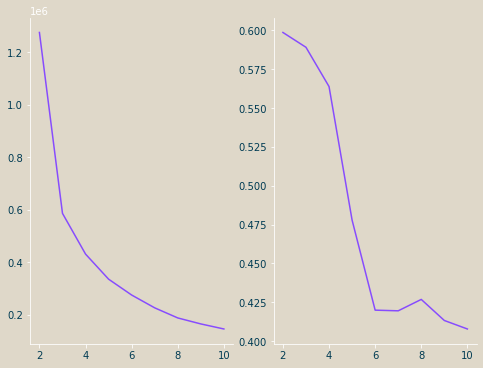

In [25]:
s_score = []
inertia = []
num_k = list(range(2, 10+1))

for k in num_k:
    kmeans = KMeans(n_clusters=k).fit(wo_outliers)
    inertia.append(-kmeans.score(wo_outliers))
    s_score.append(silhouette_score(wo_outliers, kmeans.predict(wo_outliers)))

fig, ax = plt.subplots(1, 2)

ax[0].plot(num_k, inertia)
ax[1].plot(num_k, s_score)

<AxesSubplot:xlabel='target', ylabel='volume'>

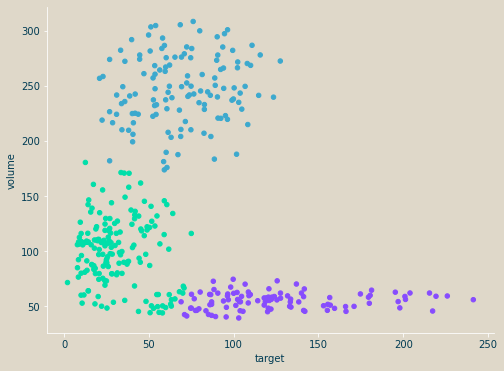

In [26]:
# According to our analysis we should use 4 clusters
cluster_alg = KMeans(n_clusters=3).fit(wo_outliers)
# Let's plot the results
wo_outliers.plot.scatter(x='target', y='volume', c=cluster_alg.predict(wo_outliers), cmap=bicmap, colorbar=False)

In [27]:
results = []
bench1_results = []
bench2_results = []

cluster_size = []

for cluster_id in range(3):
    
    # prediction for one cluster
    ids = wo_outliers[(cluster_alg.predict(wo_outliers) == cluster_id)].index
    x_segment = x.loc[ids]
    target_segment = target.loc[ids]

    print(ids.size)

    results.append(np.mean(cross_val_score(pipe, x.loc[ids], target.loc[ids], scoring=make_scorer(mean_squared_error))))
    print(f'[ML model]: {results[-1]:0.2f}')

    # Build a new Regressor for each segment
    dr = DummyRegressor(strategy='constant', constant=target.mean())
    dr.fit(x.loc[ids], target.loc[ids])
    bench1_results.append(mean_squared_error(target.loc[ids], dr.predict(x.loc[ids])))
    print(f'[Bench 1]: {bench1_results[-1]:0.2f}')

    bench2_results.append(mean_squared_error(target.loc[ids], target.loc[ids].groupby(level=0).mean().loc[customers.loc[target.loc[ids].index].index]))
    print(f'[Bench 2]: {bench2_results[-1]:0.2f}')

    cluster_size.append(ids.size)
    print('#'*30)

103
[ML model]: 11923.32
[Bench 1]: 17392.36
[Bench 2]: 9604.69
##############################
127
[ML model]: 3955.58
[Bench 1]: 3978.34
[Bench 2]: 2948.95
##############################
172
[ML model]: 812.31
[Bench 1]: 955.04
[Bench 2]: 548.94
##############################


In [28]:
# Calculate the total gain of the change
weights = np.array(cluster_size)/np.sum(cluster_size)

print(f'[ML model]: {np.average(results, weights=weights)}')

print(f'[Bench 1]: {np.average(bench1_results, weights=weights)}')

print(f'[Bench 2]: {np.average(bench2_results, weights=weights)}')

[ML model]: 4652.183067624408
[Bench 1]: 6121.713210000249
[Bench 2]: 3627.4054523669183


## **Exercise 9.4: Evaluation**

Based on the work above, evaluate your final model on the test dataset.

You can use the complete training dataset for training now.

**What is the final evaluation performance you achieve on the test set?**

In [29]:
# Train one model per cluster

results = []
bench1_results = []
bench2_results = []

models = []

for cluster_id in range(3):
    # prediction for one cluster
    ids = wo_outliers[(cluster_alg.predict(wo_outliers) == cluster_id)].index
    x_segment = x.loc[ids]
    target_segment = target.loc[ids]

    ct = make_column_transformer(
        (StandardScaler(), make_column_selector(dtype_include=np.number)),
        (OneHotEncoder(categories=[customers[s].unique() for s in ['country', 'client_group']]), make_column_selector(dtype_include=object))
    )
    pipe = make_pipeline(ct, SVR())

    pipe.fit(x.loc[ids], target.loc[ids])

    models.append(pipe)

In [30]:
# Load the test data
test_customers = pd.read_csv(
    'customers.csv',
    index_col='customer_id',
    parse_dates=['birth_date', 'customer_since'])
test_order_history = pd.read_csv(
    'order_history.csv',
    index_col=[0, 1],
    parse_dates=True)
test_order_history.index.names = ['target', 'customer_id']

In [31]:
# Perform the same operations as on the test data
test_target = test_order_history.reset_index(level=0).groupby(level=0).diff().dropna()['target'].dt.days
test_x = customers.loc[test_target.index, features]

avg_order_freq = test_target.groupby(level=0).mean()
avg_order_size = test_order_history.groupby(level=-1).mean()

agg_customers = avg_order_freq.to_frame().join(avg_order_size)

In [32]:
# Remove the outliers
wo_outliers = agg_customers[iforest.predict(agg_customers)==1]
outliers = agg_customers[iforest.predict(agg_customers)==0]

results = []
size = []

# for the outliers predict the mean
mean = target.mean()

if not outliers.empty:
    results.append(
        mean_squared_error(
            test_target[outliers.index],
            [mean for i in range(outliers.index.size)]
        ))
    size.append(outliers.index.size)

for cluster_id in range(3):
    # prediction for one cluster
    ids = wo_outliers[(cluster_alg.predict(wo_outliers) == cluster_id)].index
    x_segment = test_x.loc[ids]
    target_segment = test_target.loc[ids]

    results.append(mean_squared_error(target_segment, models[cluster_id].predict(x_segment)))
    size.append(ids.size)

weights = np.array(size)/np.sum(size)

print(f'[ML model]: {np.average(results, weights=weights)}')

[ML model]: 4557.5654343459455
